# Deep learning for Computer Vision - Pytorch

In this workbook I experiment with:

* Pytorch basics - using as a GPU alternative for Numpy
* Practising deep learning with PyTorch for solving fundamental Computer Vision tasks (image recognition)

In [28]:
import torch

## 1. Pytorch Basics

PyTorch replaces arrays in NumPy by Tensors which optimise the computational speed on GPUs. For example,
we can define a 5x3 array with randomly initialised values as follows.

In [16]:
x = torch.rand(5, 3)
print(x)

tensor([[0.9252, 0.9233, 0.5929],
        [0.6683, 0.8897, 0.7637],
        [0.4528, 0.2366, 0.4975],
        [0.0903, 0.6621, 0.6220],
        [0.1487, 0.8198, 0.4883]])


You can get teh size of a tensor similar to Numpy

In [17]:
print(x.size())

torch.Size([5, 3])


You can perform addition of 2 tensors

In [18]:
y = torch.rand(5, 3)
z = x + y
print(z)

tensor([[1.3887, 1.0153, 1.5312],
        [1.2699, 1.3765, 1.4142],
        [0.5467, 0.9974, 0.9842],
        [1.0286, 0.7139, 1.3974],
        [0.4325, 1.2344, 0.9025]])


You can convert a tensor to a numpy array and back again.

In [19]:
t = x.numpy()
print(t)
print(type(t))

[[0.92521316 0.9232599  0.5928533 ]
 [0.6683113  0.8897363  0.76373655]
 [0.4528318  0.2366392  0.4975009 ]
 [0.09029496 0.66213477 0.6220192 ]
 [0.14871871 0.81981385 0.4883319 ]]
<class 'numpy.ndarray'>


and back again

In [20]:
u = torch.from_numpy(t)
print(u)
print(type(u))

tensor([[0.9252, 0.9233, 0.5929],
        [0.6683, 0.8897, 0.7637],
        [0.4528, 0.2366, 0.4975],
        [0.0903, 0.6621, 0.6220],
        [0.1487, 0.8198, 0.4883]])
<class 'torch.Tensor'>


You can define a network manually. This makes implementing networks from research papers easier and you can design your own custom networks, optimisation functions and training loops.

Below is a very basic network.

In [21]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
     torch.nn.Linear(D_in, H),
     torch.nn.ReLU(),
     torch.nn.Linear(H, D_out),)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()
    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

99 47.526123046875
199 0.6265226602554321
299 0.0031022680923342705
399 4.710472239821684e-06
499 1.3482810423681713e-09


You can define a network as a class

In [22]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out): #D_in: input layer, H: hidden layer, D_out: output layer
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

And then use that class as shown below.

In [23]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    
    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())
        
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

99 2.549914836883545
199 0.07018032670021057
299 0.003775988472625613
399 0.00026235805125907063
499 2.067236346192658e-05


## 2. Deep Learning with PyTorch

In this section, I build a convolutional neural network (CNN), train and test it in PyTorch. I
will consider the task of image classification on CIFAR10 dataset as a case study. In this dataset there are 10
classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR10 are of size 3x32x32, i.e., 3-channel colour (RGB) images of 32x32 pixels in size. For more details, you are referred
to https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.

First, we need to download the training and test data. The following code will download the CIFAR10 dataset
into 'data' folder in your current working directory. This code makes use of torchvision.datasets and
torch.utils.data.DataLoader, which you can find more details at
https://pytorch.org/docs/stable/torchvision/datasets.html.

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True, #for training
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4, #process only 4 images at a time
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False, #not for training
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4, #process only 4 images at a time
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


After loading the training data, you can show several training images using the following code.

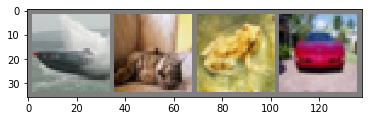

 ship   cat  frog   car


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print true labels of the images
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

I can now define the CNN. The network receives inputs as 3x32x32-dimensional tensors (i.e., 3-channel images in
size 32x32) and has the following architecture.

|Layer| Input dimension| Output dimension|
|-|-|-|
Input image||3x32x32
Conv1 (#kernels:6, kernel size:5x5, stride:1)|3x32x32|6x28x28
Pool1 (max pooling with size:2x2)|6x28x28|6x14x14
Conv2 (#kernels:16, kernel size:5x5, stride:1)|6x14x14|16x10x10
Pool2 (max pooling with size:2x2)|16x10x10|16x5x5
Fc1|16x5x5|120
Fc2|120|84
Fc3|84|10

Where Conv: convolutional layer, Pool: pooling layer, Fc: fully-connected layer.
* For convolutional layers, see more at https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html
* For max pooling layers, see more at https://pytorch.org/docs/master/generated/torch.nn.MaxPool2d.html
* For full-connected layers, see more at https://pytorch.org/docs/master/generated/torch.nn.Linear.html

I use RELU for the activation functions. The code below shows how to define such a network. Since Pool1 and
Pool2 are exactly same (i.e., the same max pooling operation and the same pooling size: 2x2), I will use only
one nn.MaxPool2d(2,2) to implement both Pool1 and Pool2.

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #x = self.conv1(x), x = F.relu(x), x = self.pool(x)
        x = self.pool(F.relu(self.conv2(x))) #x = self.conv2(x), x = F.relu(x), x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5) #flatten a 16x5x5 tensor to 16x5x5-dimensional vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

Next, I define a loss function and optimizer for our network. I will use Classification Cross-Entropy loss and
Stochastic Gradient Descent (SGD) optimizer, where learning rate (lr) is set to 0.001 and momentum is set to
0.9.

In [27]:
import torch.optim as optim
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

The network is now ready for training. I will use 2 epochs in this example i.e., we scan the whole training
dataset 3 times. The network can be trained using the following code. 

Note that, during training, The loss function is logged to keep track of the learning loss.

[1,  2000] loss: 2.201
[1,  4000] loss: 1.839
[1,  6000] loss: 1.639
[1,  8000] loss: 1.567
[1, 10000] loss: 1.508
[1, 12000] loss: 1.459
[2,  2000] loss: 1.397
[2,  4000] loss: 1.357
[2,  6000] loss: 1.370
[2,  8000] loss: 1.329
[2, 10000] loss: 1.306
[2, 12000] loss: 1.306
Finished Training
Training time in 76.23909139633179 seconds ---


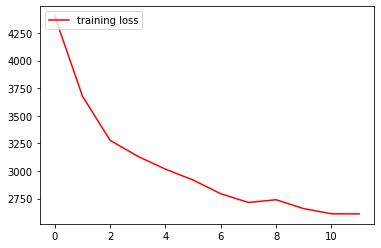

In [29]:
loss_history = []
epoch = 2

start_time = time.time()

for e in range(epoch): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
         # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (e + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0

print('Finished Training')

print("Training time in %s seconds ---" % (time.time() - start_time))

plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = "upper left")
plt.show()

Since training takes time, I should save the model after training by doing.

In [30]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Next, I will test the network. You can show the first few images from our test set and their corresponding labels
from the ground truth.

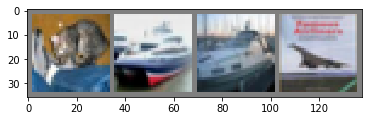

GroundTruth:    cat  ship  ship plane


In [31]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [32]:
#load the trained network
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

In [33]:
_, predicted_labels = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted_labels[j]]
    for j in range(4)))

Predicted:    cat   car   car plane


To fully and quatitatively evaluate the network, we calculate the network's overall accuracy across all image
classes on the entire test set as follows.

In [34]:
start_time = time.time()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data
        outputs = net(images)
        _, predicted_labels = torch.max(outputs.data, 1)
        total += groundtruth_labels.size(0)
        correct += (predicted_labels == groundtruth_labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

print("Testing time is in %s seconds ---" % (time.time() - start_time))

Accuracy of the network on the 10000 test images: 55 %
Testing time is in 6.094024658203125 seconds ---


To further investigate the above result, you can evaluate the per-class accuracy of the network as follows.

In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

gt_labels = np.empty((0), int)
pred_labels = np.empty((0), int)

with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data
        gt_labels = np.append(gt_labels, groundtruth_labels, axis=0)
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
        pred_labels = np.append(pred_labels, predicted_labels, axis=0)
        c = (predicted_labels == groundtruth_labels).squeeze()
        for i in range(4):
            label = groundtruth_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
    
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
    classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 40 %
Accuracy of   car : 76 %
Accuracy of  bird : 37 %
Accuracy of   cat : 33 %
Accuracy of  deer : 49 %
Accuracy of   dog : 43 %
Accuracy of  frog : 74 %
Accuracy of horse : 66 %
Accuracy of  ship : 77 %
Accuracy of truck : 59 %


### Printing the confusion matrix
Here I define a function that was adapted from a [blog post](https://deeplizard.com/learn/video/0LhiS6yu2qQ) for plotting the confusion matrix nicely. The standard one from sklearn (sklearn.metrics.plot_confusion_matrix) required you to pass in the estimator as part of the call. this one just takes the standard confusion matrix array and sopme labels.

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """ Adapted from blog post: https://deeplizard.com/learn/video/0LhiS6yu2qQ"""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        fmt = '.2%'
    else:
        fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
              precision    recall  f1-score   support

       plane       0.79      0.40      0.53      1000
         car       0.61      0.76      0.68      1000
        bird       0.47      0.38      0.42      1000
         cat       0.40      0.33      0.37      1000
        deer       0.45      0.49      0.47      1000
         dog       0.52      0.43      0.47      1000
        frog       0.58      0.74      0.65      1000
       horse       0.60      0.67      0.63      1000
        ship       0.60      0.77      0.67      1000
       truck       0.59      0.60      0.59      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.55     10000
weighted avg       0.56      0.56      0.55     10000



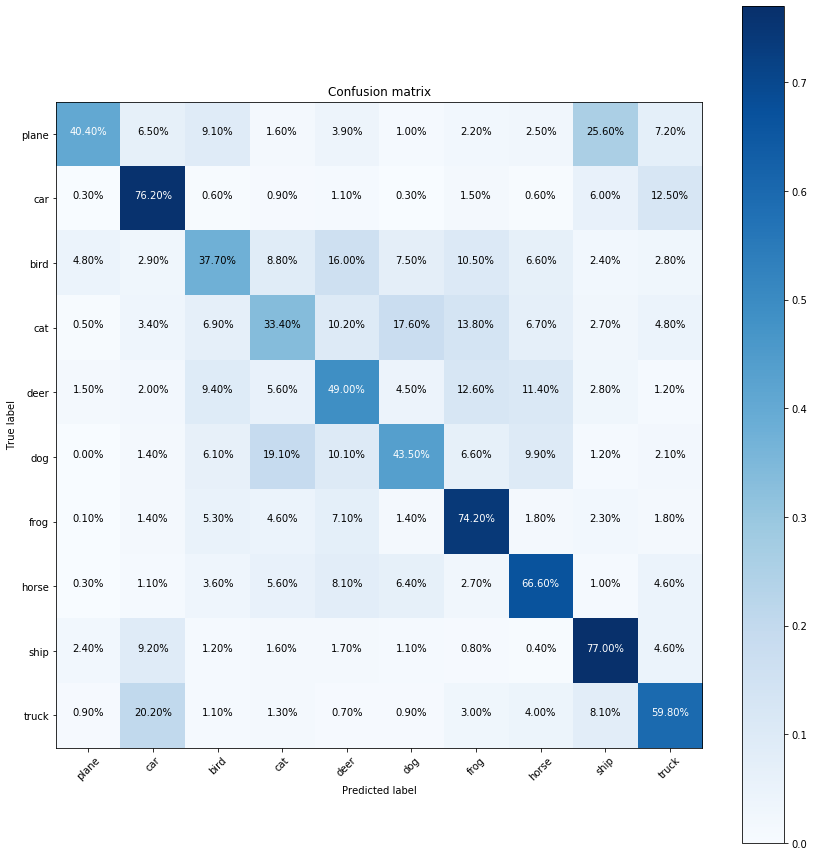

In [37]:
cm = confusion_matrix(gt_labels, pred_labels, normalize='true')
plot_confusion_matrix(cm, classes, normalize=True)
plt.savefig('confusion_matrix.png')
print(classification_report(gt_labels, pred_labels, target_names=classes))